In [67]:
import os
import logging
from tqdm import tqdm
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from util.dataset import ECL,WTH,ETT
from util.metrics import MAE, MSE
%matplotlib inline

logging.getLogger('prophet').setLevel(logging.WARNING)

In [29]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

def scale_data(original_data):
    sclr = StandardScaler()
    norm_data = scaler.fit_transform(original_data.iloc[:, 1:])

    original_data.iloc[:, 1:] = norm_data
    return original_data, sclr

In [70]:
def cross_valid(data, training_len, predict_len, sample_n, show=False,freq="H"):
    L, N = data.shape
    total_len = training_len + predict_len
    stride = (L - total_len) // ((sample_n - 1) if sample_n > 1 else 1)

    preds = np.zeros((sample_n, predict_len))
    gts = np.zeros((sample_n, predict_len))

    bar = tqdm(total=sample_n)
    for i in range(sample_n):
        data_part = data.iloc[stride * i:stride * i + total_len, :]
        train_data, test_data = data_part.iloc[:-predict_len, :], data_part.iloc[-predict_len:, :]

        m = Prophet()
        m.fit(train_data)
        future = m.make_future_dataframe(periods=predict_len, freq=freq)  # shape: (len(train_data) + pre_len, 2)
        forecast = m.predict(future)

        pred = np.array(forecast.yhat[-predict_len:])
        ground_truth = np.array(test_data.iloc[:, 1])
        if show:
            plt.plot(pred, label="Pred")
            plt.plot(ground_truth, label="GT")
            plt.legend()

        preds[i] = pred
        gts[i] = ground_truth
        bar.update()

    mse = np.mean(MSE(preds, gts))
    mae = np.mean(MAE(preds, gts))
    mtc = {"mse": mse, "mae": mae}
    return mtc


def predict(training_data: pd.DataFrame, testing_data: pd.DataFrame, show=True):
    train_len, pre_len = training_data.shape[0], testing_data.shape[0]

    m = Prophet()
    m.fit(mt320_training)

    future = m.make_future_dataframe(periods=pre_len, freq="H")  # shape: (len(train_data) + pre_len, 2)
    # print(future.tail())

    forecast = m.predict(future)  # ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    # print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    pred = np.array(forecast.yhat[-pre_len:])
    ground_truth = np.array(testing_data.iloc[:, 1])

    mtc = dict()
    mtc["mse"] = MSE(pred, ground_truth)
    mtc["mae"] = MAE(pred, ground_truth)

    if show:
        plt.plot(pred, label="Pred")
        plt.plot(ground_truth, label="GT")
        plt.legend()

    return m, mtc

# ECL

In [4]:
# normalize
ecl_data = ECL().df

scaler = StandardScaler()
ecl_data_norm = scaler.fit_transform(ecl_data.iloc[:, 1:])

ecl_data.iloc[:, 1:] = ecl_data_norm
ecl_data.head()
print(ecl_data.shape)

(26304, 322)


## 1. univariate long sequence time-series

{'mse': array([0.20427291]), 'mae': array([0.33883482])}


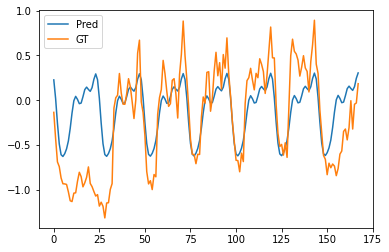

In [18]:
pre_len, train_len, offset = 168, 168, 0
# mt320 = ecl_data.iloc[-(train_len + pre_len) - offset:-offset if offset != 0 else None, [0, -1]].rename(
#     columns={"date": "ds", "MT_320": "y"})

mt320 = ecl_data.iloc[:(train_len + pre_len), [0, -1]].rename(
    columns={"date": "ds", "MT_320": "y"})
mt320_training = mt320.iloc[:-pre_len, :]
mt320_testing = mt320.iloc[-pre_len:, :]
# print(mt320.head(5))
with suppress_stdout_stderr():
    model, metrics = predict(mt320_training, mt320_testing)
print(metrics)

In [23]:
mt320_all = ecl_data.iloc[:, [0, -1]].rename(columns={"date": "ds", "MT_320": "y"})
pre_len, train_len = 168, 168
with suppress_stdout_stderr():
    metric = cross_valid(mt320_all, train_len, pre_len, 500)
print(metric)

100%|██████████| 500/500 [07:49<00:00,  1.06it/s]

{'mse': 2.097184660937773, 'mae': 1.1077438408469207}


In [26]:
print("ECL:", metric)

ECL: {'mse': 2.097184660937773, 'mae': 1.1077438408469207}


# WHT

In [34]:
wth_data = WTH().df
wth_norm, wth_scaler = scale_data(wth_data)
print(wth_norm.shape)
wth_norm.head()

(35064, 13)


,date,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,Altimeter,WetBulbCelsius
0,1/1/2010 0:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,0.278284,-0.025625,0.681993,0.652382,-1.641876
1,1/1/2010 1:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,-0.134472,0.170172,0.624802,0.608931,-1.641876
2,1/1/2010 2:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,-0.134472,0.561768,0.681993,0.652382,-1.641876
3,1/1/2010 3:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,0.278284,0.463869,0.681993,0.652382,-1.641876
4,1/1/2010 4:00,0.301781,-1.580651,-1.605506,-1.553935,-0.876306,-0.911101,0.960769,0.071906,-0.123524,0.624802,0.608931,-1.598387


In [41]:
wth_wetbulb = wth_norm.iloc[:, [0,-1]].rename(columns={"date": "ds", "WetBulbCelsius": "y"})
wth_pre_len, wth_train_len = 168, 168
with suppress_stdout_stderr():
    wth_metric = cross_valid(wth_wetbulb, wth_train_len, wth_pre_len, 500)

100%|██████████| 500/500 [07:50<00:00,  1.06it/s]


In [48]:
print("WTH", wth_metric)

WTH {'mse': 1.4274611977953522, 'mae': 0.7837144648625112}


# ETT

In [43]:
ett_data = ETT()

## ETTh1

In [44]:
ett_h1_data = ett_data.df_h1
etth1_norm, etth1_scaler = scale_data(ett_h1_data)
print(etth1_norm.shape)
etth1_norm.head()

(17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.219049,-0.114207,-0.395683,-0.231903,0.976355,0.805738,2.008513
1,2016-07-01 01:00:00,-0.238009,-0.081400,-0.411356,-0.251800,0.923970,0.857445,1.688203
2,2016-07-01 02:00:00,-0.313849,-0.245432,-0.442557,-0.291043,0.610524,0.602247,1.688203
3,2016-07-01 03:00:00,-0.323329,-0.147013,-0.442557,-0.271146,0.636286,0.703993,1.368010
4,2016-07-01 04:00:00,-0.285409,-0.147013,-0.411356,-0.231903,0.688671,0.703993,1.006610


In [49]:
etth1_OT = etth1_norm.iloc[:, [0,-1]]
etth1_OT.columns = ["ds", "y"]
etth1_pre, etth1_train_len = 168, 168
with suppress_stdout_stderr():
    etthi_metric = cross_valid(etth1_OT, etth1_train_len, etth1_pre, 500)

100%|██████████| 500/500 [07:27<00:00,  1.12it/s]


In [50]:
print("ETTh1", etthi_metric)

ETTh1 {'mse': 0.907180443383904, 'mae': 0.674066382677807}


## ETTh2

In [68]:
ett_h2_data = ett_data.df_h2
etth2_norm, etth2_scaler = scale_data(ett_h2_data)
print(etth2_norm.shape)
etth2_norm.head()

(17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,0.385246,0.655026,-0.558680,0.236445,1.277232,0.564973,1.013854
1,2016-07-01 01:00:00,0.032750,0.265509,-0.757815,-0.181105,1.279023,0.549006,0.884479
2,2016-07-01 02:00:00,0.073753,0.460351,-0.651048,0.156738,0.898991,0.346932,0.829045
3,2016-07-01 03:00:00,0.172104,0.557689,-0.634658,0.254998,1.107317,0.549006,0.588759
4,2016-07-01 04:00:00,0.090096,0.488090,-0.644921,0.297830,0.888575,0.346932,0.440878


In [71]:
etth2_OT = etth2_norm.iloc[:, [0,-1]]
etth2_OT.columns = ["ds", "y"]
etth2_pre, etth2_train_len = 168, 168
with suppress_stdout_stderr():
    etth2_metric = cross_valid(etth2_OT, etth2_train_len, etth2_pre, 500,freq="H")

100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


In [72]:
print("ETTm1", etth2_metric)

ETTm1 {'mse': 0.9993206794132539, 'mae': 0.7090322086433074}
